In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import random
from nxsim import NetworkSimulation, BaseNetworkAgent, BaseLoggingAgent
from IPython.core.debugger import set_trace
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook')

In [3]:
def census_to_df(log, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the sum of agents with a given state_id at 
    every time interval of the simulation for every run of the simulation as a pandas
    DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        census = [sum([1 for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == state_id]) 
                  for t, g in trial.items()]
        D[name] = census      
    return pd.DataFrame(D)

def graph_measurses_df(log, func, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the provided network measure for the
    topology at every time interval of the simulation for every run of the
    simulation as a pandas DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        measure = [func(nx.Graph(trial[key]['topology'])) 
                   for key in trial]
        D[name] = measure 
    return pd.DataFrame(D)

def friends_to_the_end(log, num_trials=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the number of human friends connected
    to every human at every time interval of the simulation for every run of
    the simulation as a pandas DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        friends = [np.mean([state['friends'] for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == 0]) 
                  for t, g in trial.items()]
        D[name] = friends    
    return pd.DataFrame(D)    

In [19]:
class SZR(BaseNetworkAgent):
    
    inf_prob = 0.3
    kill_prob = 0.2
    
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
    def run(self):
        while True:
            if self.state['id'] == 0:
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            elif self.state['id'] == 1:
                self.check_for_elimination()
                yield self.env.timeout(1)
            else:
                yield self.env.event()
    
    def check_for_elimination(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        if(len(human_neighbors) > 0):
            #neighbor = random.choice(human_neighbors)
            if random.random() < self.kill_prob:
                self.state['id'] = 2
                #print(self.env.now, self.id, '<--', neighbor.id, sep='\t')
    
    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        if(len(zombie_neighbors) > 0):
            #neighbor = random.choice(zombie_neighbors)
            if random.random() < self.inf_prob:
                self.state['id'] = 1
                #print(self.env.now, self.id, '<--', neighbor.id, sep='\t')
                                
    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

In [12]:
number_of_nodes = 100
G = nx.barabasi_albert_graph(number_of_nodes,2)
log_path = 'SZR_noloop'

In [20]:
%%capture capt_log_sim1

# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=SZR, 
                        max_time=28, num_trials=100, logging_interval=1, dir_path=log_path)

# Running the simulation
sim.run_simulation()

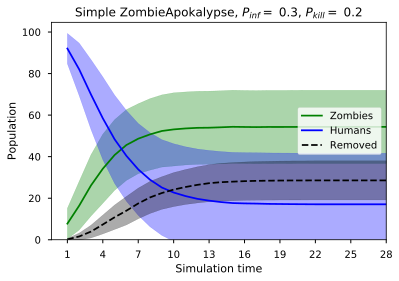

In [21]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path= log_path).T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path= log_path).T
removed = census_to_df(BaseLoggingAgent, 100, 2, dir_path= log_path).T

plt.plot(zombies.mean(), color='g')
plt.fill_between(zombies.columns, zombies.mean() + zombies.std(), zombies.mean() - zombies.std(), color='g', alpha=.33)

plt.plot(humans.mean(), color='b')
plt.fill_between(humans.columns, humans.mean() + humans.std(), humans.mean() - humans.std(), color='b', alpha=.33)

plt.plot(removed.mean() , '--k')
plt.fill_between(removed.columns, removed.mean() + removed.std(), removed.mean() - removed.std(), color='k', alpha=.33)

plt.title('Simple ZombieApokalypse, $P_{inf}=$ ' + str(SZR.inf_prob) + ', $P_{kill}=$ ' + str(SZR.kill_prob))
plt.legend(['Zombies', 'Humans','Removed'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.ylim(ymin=0)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time');


/home/nick/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


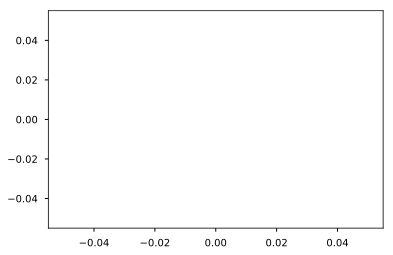

In [18]:
x = np.linspace(0,28,0.1)
y = np.exp(-0.3*x) - np.exp(-0.2*x)
plt.plot(x,y)

In [5]:
def run_simulation_on_Graph(G,log_path):
    num_trials = 100
    number_of_nodes = G.number_of_nodes()
    # Starting out with a human population
    init_states = [{'id': 0, } for _ in range(number_of_nodes)]

    # Randomly seeding patient zero
    patient_zero = random.randint(0, number_of_nodes)
    init_states[patient_zero] = {'id': 1}

    # Setting up the simulation
    sim = NetworkSimulation(topology=G, states=init_states, agent_type=SZR, 
                        max_time=28, num_trials=num_trials, logging_interval=1, dir_path=log_path)

    # Running the simulation
    sim.run_simulation()

def plot_Sim_Results(log_path,num_trials = 100):    
    zombies = census_to_df(BaseLoggingAgent, num_trials, 1, dir_path= log_path).T
    humans = census_to_df(BaseLoggingAgent, num_trials, 0, dir_path= log_path).T
    removed = census_to_df(BaseLoggingAgent, num_trials, 2, dir_path= log_path).T
#     set_trace()
#     zmean = zombies.mean()
#     zmean.loc[-1] = 1
#     zmean.index = zmean.index + 1
#     zmean = zmean.sort()
    plt.plot(zombies.mean(),'go')
    plt.fill_between(zombies.columns, zombies.mean() + zombies.std(), zombies.mean() - zombies.std(), color='g', alpha=.33)

    plt.plot(humans.mean(), 'bo')
    plt.fill_between(humans.columns, humans.mean() + humans.std(), humans.mean() - humans.std(), color='b', alpha=.33)

    plt.plot(removed.mean() , '--k')
    plt.fill_between(removed.columns, removed.mean() + removed.std(), removed.mean() - removed.std(), color='k', alpha=.33)

    plt.title('Simple ZombieApokalypse, $P_{inf}=$ ' + str(SZR.inf_prob) + ', $P_{kill}=$ ' + str(SZR.kill_prob))
    plt.legend(['Zombies', 'Humans','Removed'], loc=7, frameon=True)
    plt.xlim(xmax=27)
    plt.ylim(ymin=0)
    plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
    plt.ylabel('Population')
    plt.xlabel('Simulation time');

In [7]:
%%capture capt_log_sim1
G = nx.barabasi_albert_graph(1000,3)
log_path = 'SZR_BA_3'
run_simulation_on_Graph(G,log_path)
G = nx.barabasi_albert_graph(1000,7)
log_path = 'SZR_BA_7'
run_simulation_on_Graph(G,log_path)
G = nx.barabasi_albert_graph(1000,9)
log_path = 'SZR_BA_9'
run_simulation_on_Graph(G,log_path)

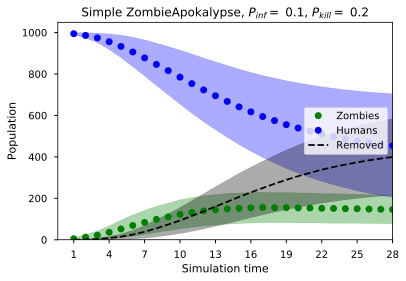

In [8]:
plot_Sim_Results('SZR_BA_3')

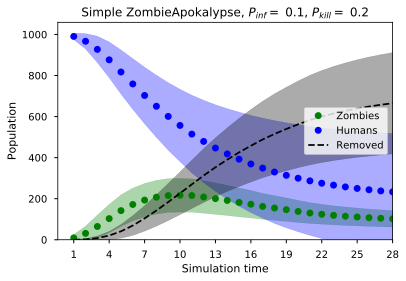

In [9]:
plot_Sim_Results('SZR_BA_7')

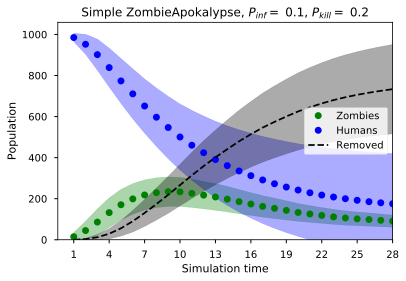

In [10]:
plot_Sim_Results('SZR_BA_9')

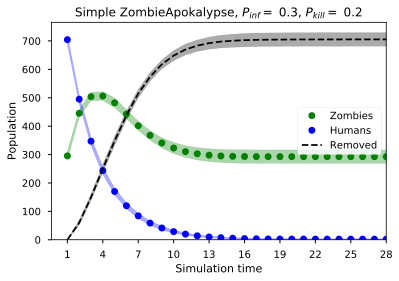

In [55]:
plot_Sim_Results('SZR_BA_15')